# Photutils Tutorial
I am following the user guide on the photutils website to learn the basic options that Photutils offers.

# Detecting Stars

Main Objective: see the functionality of DAOFinder

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.stats import (sigma_clipped_stats, SigmaClip, biweight_location,
                          mad_std)
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize, simple_norm
from astropy.convolution import convolve

from photutils.aperture import CircularAperture
from photutils.datasets import load_star_image, make_100gaussians_image
from photutils.detection import DAOStarFinder, find_peaks
from photutils.background import Background2D, MedianBackground
from photutils.utils import circular_footprint
from photutils.segmentation import (SourceFinder,
                                detect_sources, detect_threshold,
                                deblend_sources, make_2dgaussian_kernel, # makes a normalized 2D circular Gaussian kernel
                                SourceCatalog)
from photutils.psf import (CircularGaussianPRF, fit_fwhm,
                           make_psf_model_image)

from scipy.ndimage import rotate

In [28]:
hdu = load_star_image()
data = hdu.data[0:401, 0:401]
mean, median, std = sigma_clipped_stats(data, sigma=3.0) # done to remove outliers
print(np.array((mean, median, std)))

[3668.09661146 3649.          204.41388592]


In [29]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'    # for consistent table output

sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness ...   peak     flux    mag   daofind_mag
--- --------- --------- --------- ... ------- --------- ------ -----------
  1    144.25      6.38      0.58 ... 6903.00  45735.00 -11.65       -1.89
  2    208.67      6.82      0.48 ... 7896.00  62118.00 -11.98       -2.07
  3    216.93      6.58      0.69 ... 2195.00  12436.00 -10.24       -0.55
  4    351.63      8.55      0.49 ... 6977.00  55313.00 -11.86       -1.93
  5    377.52     12.07      0.52 ... 1260.00   9078.00  -9.89       -0.12
  6    294.27     12.74      0.68 ... 2059.00  15818.00 -10.50       -0.43
  7     85.22     14.71      0.62 ... 1458.00   7413.00  -9.67       -0.24
  8    137.94     17.46      0.54 ... 5451.00  38267.00 -11.46       -1.68
  9    130.33     18.68      0.63 ... 3432.00  19551.00 -10.73       -1.14
 10    143.11     18.62      0.52 ... 6722.00  48799.00 -11.72       -1.90
...       ...       ...       ... ...     ...       ...    ...         ...
276    292.59    389.31  

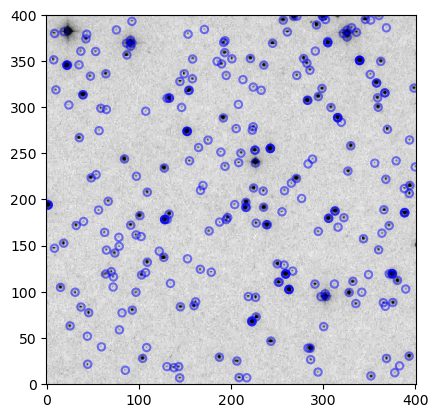

In [36]:
# Plot the image and mark the location of detected sources
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
          interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

## Masking Regions

In [10]:
mask = np.zeros(data.shape, dtype=bool)
mask[50:151, 50:351] = True
mask[250:351, 150:351] = True
sources = daofind(data - mean, mask=mask)

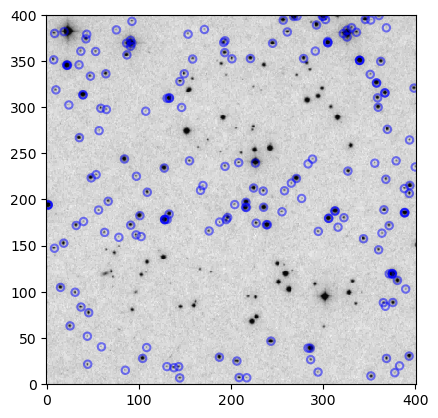

In [12]:
new_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
new_apertures = CircularAperture(new_positions, r=4.0)
new_norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=new_norm,
          interpolation='nearest')
new_apertures.plot(color='blue', lw=1.5, alpha=0.5)

## Local Peak Detection

In [23]:
data = make_100gaussians_image()
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (5.0 * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = "%.8g" # for consistent table output
print(tbl[:10])

 id x_peak y_peak peak_value
--- ------ ------ ----------
  1    233      0  27.786048
  2    493      6  18.699406
  3    208      9  22.499317
  4    259     11  16.400909
  5    365     11  17.789691
  6    290     23  34.141532
  7    379     29  16.058562
  8    442     31  32.162038
  9    471     37  24.141928
 10    358     39  18.671565


(0.0, 299.0)

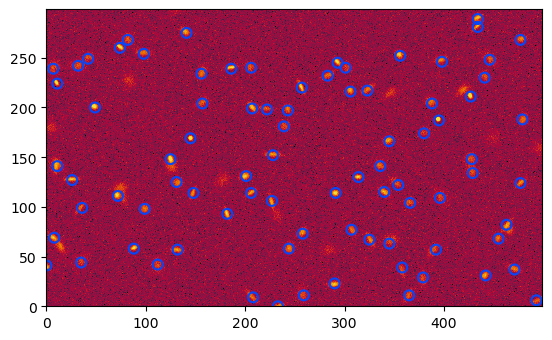

In [25]:
# plot location of the detected peaks in the image
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.0)
norm = simple_norm(data, 'sqrt', percent=99.9)
cmap = cms.ember
plt.imshow(data, cmap=cmap, origin='lower', norm=norm, 
          interpolation='nearest')
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, data.shape[1] - 1)
plt.ylim(0, data.shape[0] - 1)

# Image Segmentation

### Source Extraction using Image Segmentation

[Wikipedia](https://en.wikipedia.org/wiki/Image_segmentation): Image segmentation simplifies the representation of the image into something more meaning and easier to analyze. It is typically used to locate objects and boundaries (lines, curves, etc) in images. More precisely, it assigns labels to every pixel in an image such that pixels with the same label are part of the same source. Detected sources must have a minimum number of connected pixels that are each greater than a specified threshold value in an image. The threshold level is usually defined as some multiple of the background noise (sigma level) above the background

In [46]:
# Subtract the background from the image
# Use Background2D class to produce a background and background noise image
data = make_100gaussians_image()
bkg_estimator = MedianBackground()
bkg = Background2D(data, box_size=(50, 50), filter_size=(3, 3),
                  bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

In [44]:
threshold = 1.5 * bkg.background_rms

Now we convolve the data with a 2D Gaussian Kernel. <br>
Convolution is a process where a small matrix (kernel) is moved across an image and the values of the kernel are multiplied by the corresponding pixel values in the image. These products are then summed to produce a new pixel value for the output image. This process can be used for various image transformations, such as blurring, sharpening, and edge detection. 

In [48]:
kernel = make_2dgaussian_kernel(fwhm=3.0, size=5) 
convolved_data = convolve(data, kernel)  # convolve an array with a kernel

In [60]:
segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 86
labels: [ 1  2  3  4  5 ... 82 83 84 85 86]


Text(0.5, 1.0, 'Segmentation Image')

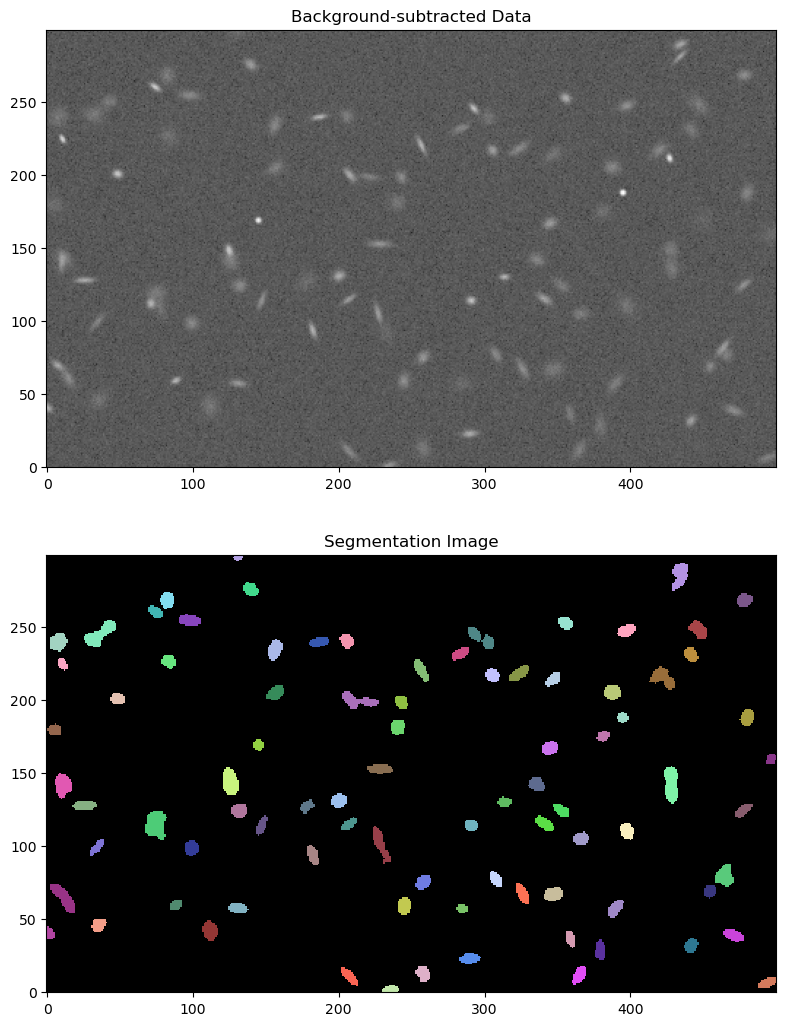

In [66]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

### Source Deblending
In the image above, overlapping sources are detected as single sources. We will use `deblend_source()` to fix that.

In [71]:
# Can control deblending with `nlevels` and `contrast`
segm_deblend = deblend_sources(convolved_data, segment_map, 
                              npixels=10,
                              nlevels=32,  # number of multi-thresholding levels to use
                              contrast=0.001,  # fraction of total source flux that a local peak must 
                                               # have to be considered a separate object
                              progress_bar=False)

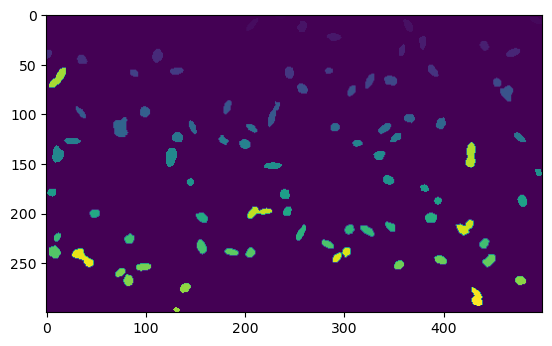

In [74]:
plt.imshow(segm_deblend)

### Source Finder
`SourceFinder` is a convenience class that combines the functionality of `detect_sources` and `deblend_sources`. After defining the object with the desired detection and deblending parameters, you call it with the background-subtracted (convolved) image and threshold:

In [76]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 93
labels: [ 1  2  3  4  5 ... 89 90 91 92 93]


### Photometry, Centroids and Shape Properties
`SourceCatalog`: class for measuring photometry, centroids and shape/morphological properties of sources defined in a segmentation image. 

In [80]:
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 93
labels: [ 1  2  3  4  5 ... 89 90 91 92 93]


In [81]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    235.38      1.44 ...             nan    490.35          nan
    2    493.78      5.84 ...             nan    489.37          nan
    3    207.29     10.26 ...             nan    694.24          nan
    4    364.87     11.13 ...             nan    681.20          nan
    5    257.85     12.18 ...             nan    748.18          nan
    6    289.79     22.39 ...             nan    941.39          nan
    7    379.21     27.86 ...             nan    635.38          nan
    8    441.42     31.26 ...             nan    742.80          nan
    9    358.54     36.08 ...             nan    449.14          nan
   10    470.62     38.22 ...             nan    792.19          nan
  ...       ...       ... ...             ...       ...          ...
   84    208.00    199.45 ...     

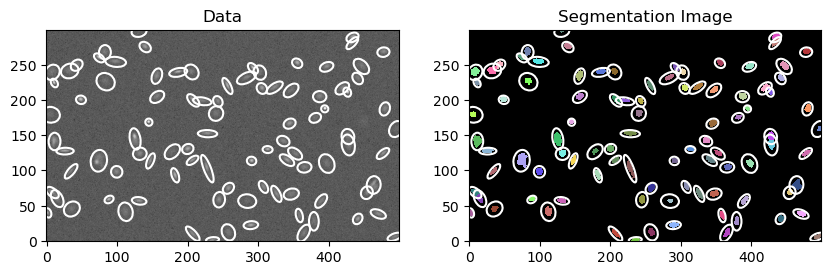

In [84]:
# Calculate Kron Apertures (based on the
# shape of each source) on the data
norm = simple_norm(data=data, stretch='sqrt')
fig, ax = plt.subplots(1, 2, figsize=(10, 12.5))
ax[0].imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax[0].set_title('Data')
ax[1].imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
            interpolation='nearest')
ax[1].set_title('Segmentation Image')
cat.plot_kron_apertures(ax=ax[0], color='white', lw=1.5)
cat.plot_kron_apertures(ax=ax[1], color='white', lw=1.5)

# [Background Estimation](https://photutils.readthedocs.io/en/2.1.0/user_guide/background.html)

## Scalar Background and Noise Estimation

### Simple Statistics

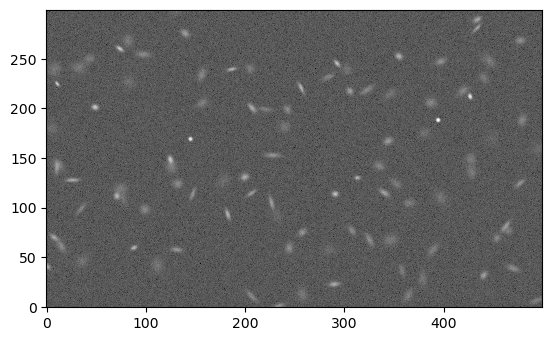

In [86]:
data = make_100gaussians_image()
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys_r',
          interpolation='nearest')

In [93]:
print(np.median(data))
print(biweight_location(data))

5.222396450477202
5.187556943476142


In [94]:
# Calculate median absolute deviation to estimate background noise level
print(mad_std(data))

2.1497096320053166


### Sigma Clipping Sources

In [96]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(np.array((mean, median, std)))

[5.19968673 5.15244174 2.09423739]


### Masking Sources
An even better procedure is to exclude the sources in the image by masking them. But, we have to identify sources first, which in turn depends upon the background and the background noise. Therefore, this is an iterative procedure. 

In [99]:
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(data, threshold, npixels=10)
footprint = circular_footprint(radius=10)
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print(np.array((mean, median, std)))

[5.00257401 4.99641799 1.97009566]


## 2D Background and Noise Estimation

Text(0.5, 1.0, 'Data with added background gradient')

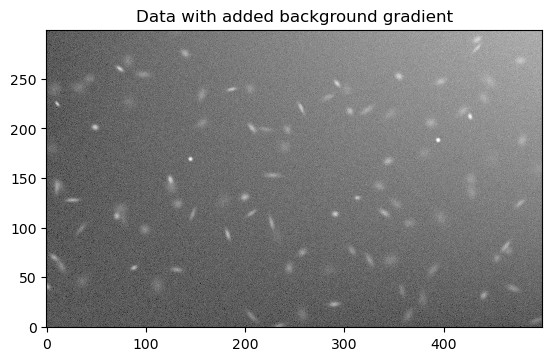

In [102]:
ny, nx = data.shape
y, x = np.mgrid[:ny, :nx]
gradient = x * y / 5000.0
data2 = data + gradient
plt.imshow(data2, norm=norm, origin='lower', cmap='Greys_r',
          interpolation='nearest')
plt.title('Data with added background gradient')

We create a `Background2D` object using a box size of 50x50 and a 3x3 median filter. We will estimate the background level in each mesh as the simga-clipped median using an instance of `MedianBackground`:

In [103]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data2, (50, 50), filter_size=(3, 3),
                  sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [104]:
print(bkg.background_median)
print(bkg.background_rms_median)

10.852487630351824
2.2629969814471496


Text(0.5, 1.0, 'Background-subtracted Data')

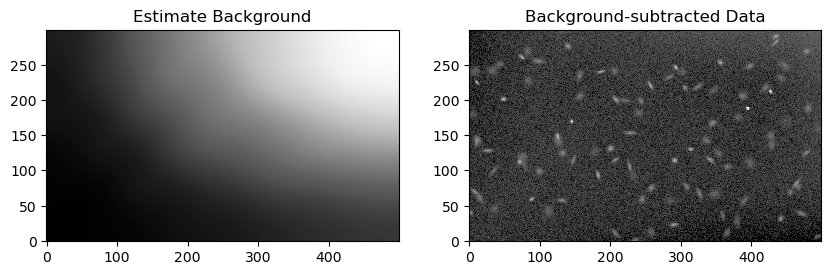

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 12.5))

ax[0].imshow(bkg.background, origin='lower', cmap='Greys_r',
            interpolation='nearest')
ax[0].set_title('Estimate Background')

ax[1].imshow(data2 - bkg.background, norm=norm, origin='lower',
            cmap='Greys_r', interpolation='nearest')
ax[1].set_title("Background-subtracted Data")

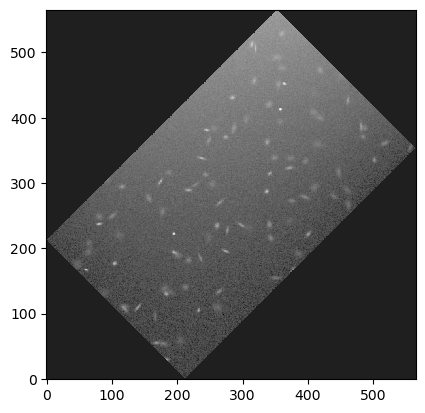

In [112]:
data3 = rotate(data2, -45.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data3, origin='lower', cmap='Greys_r', norm=norm,
          interpolation='nearest')

In [113]:
# Create Coverage mask and input into `Background2D`
# to exclude regions where we have no data
coverage_mask = (data3 == 0)
bkg3 = Background2D(data3, (15, 15), filter_size=(3, 3),
                   coverage_mask=coverage_mask, fill_value=0.0,
                   exclude_percentile=50.0)

Text(0.5, 1.0, 'Estimated Background')

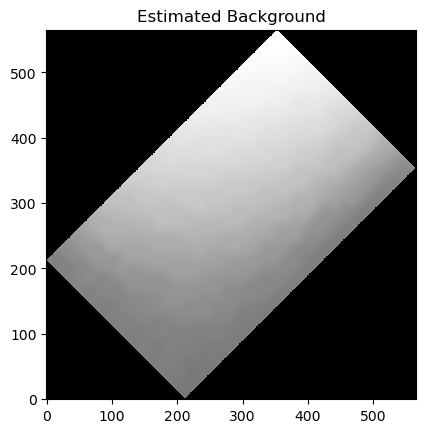

In [116]:
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(bkg3.background, origin='lower', cmap='Greys_r', norm=norm,
          interpolation='nearest')
plt.title("Estimated Background")

Text(0.5, 1.0, 'Background-subtracted Data')

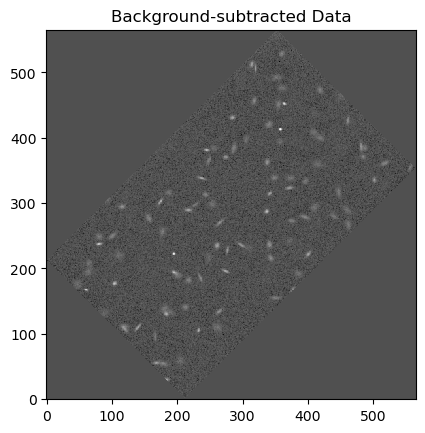

In [118]:
# Subtract Background from the image and plot it
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data3 - bkg3.background, origin='lower', cmap='Greys_r',
          norm=norm, interpolation='nearest')
plt.title('Background-subtracted Data')

### Plotting Meshes

(0.0, 250.0)

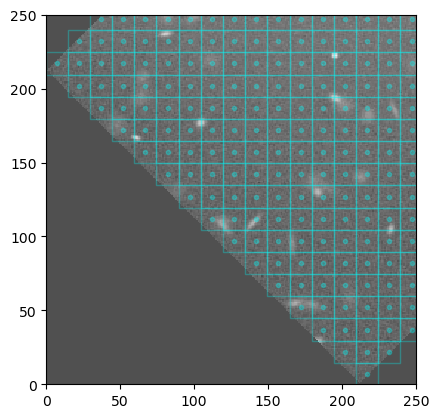

In [120]:
plt.imshow(data3, origin='lower', cmap='Greys_r', norm=norm,
          interpolation='nearest')
bkg3.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3)
plt.xlim(0, 250)
plt.ylim(0, 250)

# FWHM

## FWHM of just one source

fwhm: [3.123]


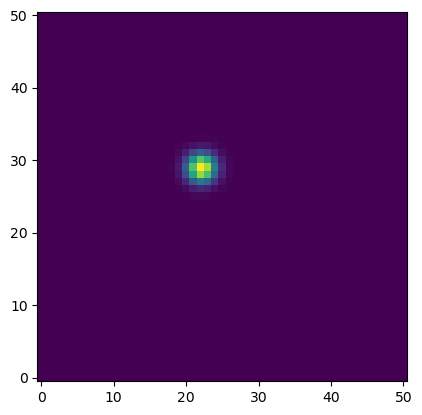

In [9]:
yy, xx = np.mgrid[:51, :51]
model = CircularGaussianPRF(x_0=22.17, y_0=28.87, fwhm=3.123, flux=9.7)
data = model(xx, yy)
fwhm = fit_fwhm(data)
print("fwhm:",fwhm)

# plot the image
plt.imshow(data, origin='lower', vmin=0, vmax=0.8)
plt.show()

## FWHM of multiple sources 

fwhms: [5.69467204 5.21376414 7.65508658 3.20255356 6.66003098]


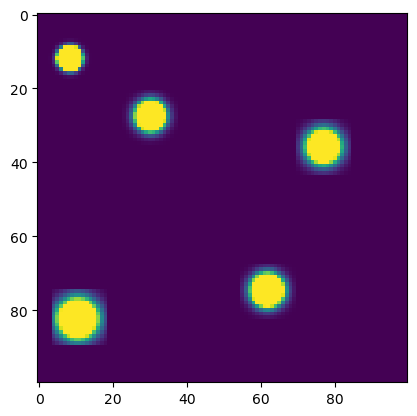

In [15]:
model = CircularGaussianPRF()
data, sources = make_psf_model_image((100, 100), model, 5,
                                     min_separation=25,
                                     model_shape=(15, 15),
                                     flux=(100, 200), fwhm=[3, 8])
finder = DAOStarFinder(0.1, 5)
finder_tbl = finder(data)
xypos = list(zip(sources['x_0'], sources['y_0']))
fwhms = fit_fwhm(data, xypos=xypos, fit_shape=7)
print("fwhms:", fwhms)

plt.imshow(data, vmin=0, vmax=0.8)
plt.show()